In [1]:
base_path = "src/nodes"

In [2]:
node_name = "sklearn_ranker"
node_folder = f"{base_path}/{node_name}"

# Config

In [3]:
import hypster
from hypster import HP

@hypster.config
def hp_config(hp: HP):
    from sklearn.feature_extraction.text import TfidfVectorizer
    top_k = hp.number_input(20)
    
    ngram_range = hp.select({"basic" : (1, 3),
                             "expanded" : (3, 8)}, default="basic")
    analyzer = hp.select(["word", "char"], default="word")
    
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, analyzer=analyzer, lowercase=True)

In [4]:
config_inputs = hp_config(selections={}, overrides={})

# Upstream Inputs

In [5]:
parent_dag_name = "rag_qa"
node_name_in_parent = "top_k_chunks"

In [6]:
from src.hypernodes import HyperNode
parent_node = HyperNode.load(f"{base_path}/{parent_dag_name}")

In [7]:
parent_node.instantiate_inputs(overrides={"user_query" : "What year was the transformer architecture introduced?"})

In [8]:
upstream_inputs = parent_node.get_node_inputs(node_name=node_name_in_parent)

# DAG

In [10]:
inputs = {**config_inputs, **upstream_inputs}
globals().update(inputs)

In [11]:
%load_ext hamilton.plugins.jupyter_magic

In [12]:
display_config = dict(output_file_path=f"{node_folder}/dag.png",
                      show_legend=False, orient="TB", hide_inputs=True)

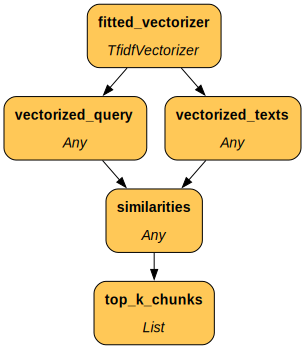

In [13]:
%%cell_to_module dag --display display_config --execute --inputs inputs --hide_results

from typing import List, Callable, Any, Union
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fitted_vectorizer(vectorizer: TfidfVectorizer, text_chunks: List[str]) -> TfidfVectorizer:
    return vectorizer.fit(text_chunks)

def vectorized_texts(fitted_vectorizer: TfidfVectorizer, text_chunks: List[str]) -> Any:
    return fitted_vectorizer.transform(text_chunks)

def vectorized_query(fitted_vectorizer: TfidfVectorizer, query: str) -> Any:
    return fitted_vectorizer.transform([query])

def similarities(vectorized_query: Any, vectorized_texts: Any) -> Any:
    cosine_similarities = cosine_similarity(vectorized_query, vectorized_texts)
    return cosine_similarities

def top_k_chunks(text_chunks: List[str], similarities: Any, top_k: int) -> List[str]:
    sorted_indices = np.argsort(similarities[0])[::-1]
    top_k_indices = sorted_indices[:top_k]
    return [text_chunks[i] for i in top_k_indices] 

In [14]:
from src.hypernodes import HyperNode

In [15]:
module = HyperNode(name=node_name,
                   dag_modules=[dag], 
                   hp_config=hp_config)

In [16]:
module.save(folder=node_folder)